In [2]:
%matplotlib inline

import sys, os
sys.path.append('/astro/users/bmmorris/git/friedrich')
from glob import glob

from friedrich.lightcurve import (LightCurve, hat11_params_morris_experiment,
                                  generate_lc_depth)
from friedrich.fitting import peak_finder, summed_gaussians, run_emcee_seeded
from scipy.ndimage import gaussian_filter
import numpy as np

# on mist
light_curve_paths = glob('/local/tmp/hat11/*slc.fits')
output_dir = os.path.abspath('./')

hat11_params = hat11_params_morris_experiment()

# Construct light curve object from the raw data
whole_lc = LightCurve.from_raw_fits(light_curve_paths, name='HAT11')
oot = LightCurve(**whole_lc.mask_in_transit(hat11_params,
                                                 oot_duration_fraction=0.25))


In [3]:
import matplotlib.pyplot as plt
from copy import deepcopy

dt_median = np.median(np.diff(oot.times.jd))
gaps = np.diff(oot.times.jd) > 5*dt_median
n_gaps = np.count_nonzero(gaps)

remaining_lc = deepcopy(oot)
chunks = []
counter = 0
order = 5

from astropy.stats import mad_std

while counter < n_gaps:
    gaps = np.diff(remaining_lc.times.jd) > 5*dt_median
    first_index = np.arange(len(gaps))[gaps][0]
    split_lc = remaining_lc.split_at_index(first_index+1)
    
    chunk = deepcopy(split_lc[0])
    
    # Normalize chunk
    time_offset = np.median(chunk.times.jd) 
    fit_params = np.polyfit(chunk.times.jd - time_offset, chunk.fluxes, order)
    original_median = np.median(chunk.fluxes)
    chunk.fluxes = chunk.fluxes/np.polyval(fit_params, chunk.times.jd - time_offset)
    chunk.errors = chunk.errors/np.polyval(fit_params, chunk.times.jd - time_offset)
    
    # Remove outliers
    inliers = np.abs(chunk.fluxes - np.median(chunk.fluxes)) < 4 * mad_std(chunk.fluxes)
    
#     plt.plot(chunk.times.jd[inliers] - time_offset, chunk.fluxes[inliers])
#     plt.show()
    
    chunk.times = chunk.times[inliers]
    chunk.fluxes = chunk.fluxes[inliers]
    chunk.errors = chunk.errors[inliers]
    
    chunks.append(chunk)
    remaining_lc = split_lc[1]
    counter += 1

In [4]:
# for chunk in chunks[30:40]:
#     chunk.plot() 

In [5]:
# Reassemble whole light curve: 
from astropy.time import Time

light_curve_list = chunks

times = []
fluxes = []
errors = []
quarters = []
for light_curve in light_curve_list:
    times.append(light_curve.times.jd)
    fluxes.append(light_curve.fluxes)
    errors.append(light_curve.errors)
    quarters.append(light_curve.quarters)
times, fluxes, errors, quarters = [np.concatenate(i)
                                   for i in [times, fluxes,
                                             errors, quarters]]

times = Time(times, format='jd')

from astropy.stats import mad_std

# mask_times = times.jd < times.jd[5000]
#mask_times = (times.jd < times.jd[10000]) & (times.jd > times.jd[5000])
mask_outliers = np.abs(np.median(fluxes) - fluxes) < 10 * np.std(fluxes)

# mask_outliers &= mask_times

normalized_lc = LightCurve(times=times[mask_outliers], fluxes=fluxes[mask_outliers], 
                           errors=errors[mask_outliers], quarters=quarters[mask_outliers])

/astro/apps6/anaconda2.0/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1455272 but corresponding boolean dimension is 1449564


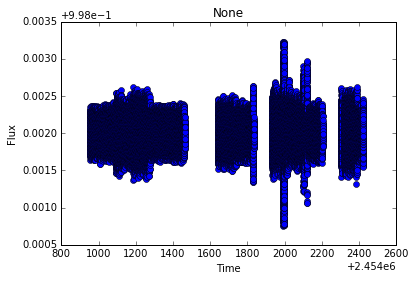

In [6]:
normalized_lc.plot()

In [7]:
# # x = [ 0.56022339, -0.84038667]

# import interpacf

# lags, acf = interpacf.interpolated_acf(normalized_lc.times.jd, 
#                                       normalized_lc.fluxes - 1)

# def kernel(p, lags):
#     amp1, tau1, tau2, tau3 = p
#     return amp1 * (np.exp(-lags/tau1**2) * np.cos(2*np.pi/tau2 * lags) + np.exp(-lags/tau3**2))
# #    return (1 + np.sqrt(3*lags**2) * np.exp(-np.sqrt(3*lags**2)))

# def minimizethis(p, lags):
#     return np.sum((kernel(p, lags[1:]) - acf[1:])**2)

# from scipy.optimize import fmin_bfgs, fmin_powell

# results = fmin_powell(minimizethis, [2e-6, 1.2649, 0.348, 0.1732], args=(lags, ))

# print(results)
# # fig, ax = plt.subplots(1, 2, figsize=(12, 10))

# plt.figure(figsize=(10, 8))
# plt.plot(lags[1:], acf[1:]*1e6, label='HAT-P-11')
# plt.plot(lags, kernel(results, lags)*1e6, 'r', label='model')
# plt.xlabel('Lag [days]')
# plt.ylabel('autocorrelation')
# plt.legend()
# plt.show()
# # plt.savefig('')
# # ax[1].plot(lags[1:], acf[1:] - kernel(results, lags[1:]))
# #plt.loglog(lag, acf)

In [8]:
# plt.figure(figsize=(12, 10))
# plt.plot(lags[1:], acf[1:])

# plt.plot(lags[1:], 8e-6 * np.exp(-lags[1:]/0.03))
# plt.plot(lags[1:], 2e-6 * np.cos(2*np.pi/0.35 * lags[1:]))
# plt.plot(lags[1:], 2e-6 * np.cos(2*np.pi/0.345 * lags[1:]) * np.exp(-lags[1:]/1.2649**2), lw=3)
# plt.plot(lags[1:], 2e-6 * (np.cos(2*np.pi/0.345 * lags[1:]) * np.exp(-lags[1:]/1.2649**2) + 
#                            np.exp(-lags[1:]/0.1732**2)), lw=3)
# plt.show()

(array([  64.,   46.,   50.,   56.,   48.,   47.,   43.,   54.,   36.,  145.]),
 array([ 0.00817377,  0.30692228,  0.60567078,  0.90441929,  1.2031678 ,
         1.5019163 ,  1.80066481,  2.09941332,  2.39816182,  2.69691033,
         2.99565883]),
 <a list of 10 Patch objects>)

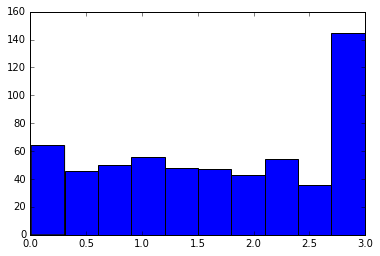

In [9]:
l = []
for i, chunk in enumerate(chunks):
    l.append(chunk.times.jd.ptp())
    
plt.hist(l)


[  2.06583227e-06   3.65654073e-01   9.99539596e-01   7.91655863e-01]


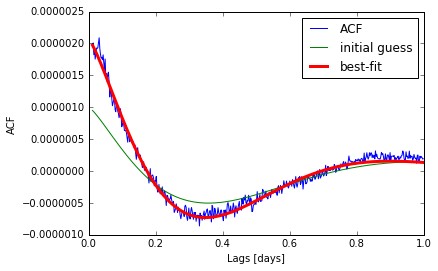

In [77]:
import interpacf

def kernel(p, lags):
    amp1, tau1, tau2, gamma = p
    return amp1 * np.exp(-lags/np.abs(tau1)) * np.cos(2*np.pi/tau2 * lags**gamma)

def grad_kernel(p, lags):
    amp1, tau1, tau2, gamma = p
    return (-amp1/tau1 * np.exp(-lags/np.abs(tau1)) * np.cos(2*np.pi/tau2 * lags**gamma) + 
            -amp1 * np.exp(-lags/tau1) * 2*np.pi/tau2 * gamma * lags**(gamma - 1) * 
            np.sin(2*np.pi/tau2 * lags**gamma))

bestps = []
all_lags = []
all_acfs = []
all_lags_min = 1e10
all_lags_max = -1e10
all_stds = []
zero_lag = []
for i, chunk in enumerate(chunks):
    if chunk.times.jd.ptp() > 2.0:
        lags, acf = interpacf.interpolated_acf(chunk.times.jd, 
                                               chunk.fluxes - np.median(chunk.fluxes))
        all_lags.append(lags)
        all_acfs.append(acf) # /acf.max())
        all_stds.append(chunk.fluxes.std())
        zero_lag.append(acf[0])
        
        if all_lags_min > lags.min():
            all_lags_min = lags.min()
        if all_lags_max < lags.max():
            all_lags_max = lags.max()

bin_edges = np.linspace(0.01, 1.0, 500)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
medians = np.zeros(len(bin_centers))
for i in range(len(bin_edges) - 1):
    collect_lags = []
    for j in range(len(all_lags)):
        in_bin = (all_lags[j] > bin_edges[i]) & (all_lags[j] < bin_edges[i+1])
        collect_lags.extend(all_acfs[j][in_bin].tolist())
    medians[i] = np.median(collect_lags)

def minimizethis(p, lags):
    return np.sum((kernel(p, lags[ignore:]) - medians[ignore:])**2)

from scipy.optimize import fmin_bfgs, fmin_powell

initp = [1e-6, 0.56, 1.08, 0.7]
ignore = 0
results = fmin_powell(minimizethis, initp, args=(bin_centers, ), 
                      disp=False)
print(results)
plt.plot(bin_centers, medians, label='ACF')
plt.plot(bin_centers, kernel(initp, bin_centers), label='initial guess')
plt.plot(bin_centers, kernel(results, bin_centers), lw=3, label='best-fit')
plt.xlabel('Lags [days]')
plt.ylabel('ACF')
plt.legend()

In [11]:
results

array([  2.06583227e-06,   3.65654073e-01,   9.99539596e-01,
         7.91655863e-01])

4.63754918255e-05


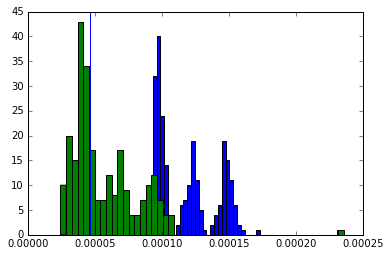

In [80]:
typical_error = np.median(zero_lag)
print(typical_error)
plt.axvline(typical_error)
plt.hist(all_stds, 50)
plt.hist(zero_lag, 50);

In [13]:
from george.kernels import PythonKernel
from george import GP, BasicSolver

def best_kernel(x1, x2, p):
    return kernel(p, np.abs(x1-x2))

def best_grad_kernel(x1, x2, p):
    return grad_kernel(p, np.abs(x1-x2))


custom_kernel = PythonKernel(f=best_kernel, g=best_grad_kernel, pars=results)
x = np.arange(0, 0.1, 1./60/24)

gp = GP(custom_kernel, solver=BasicSolver)
gp.compute(x)

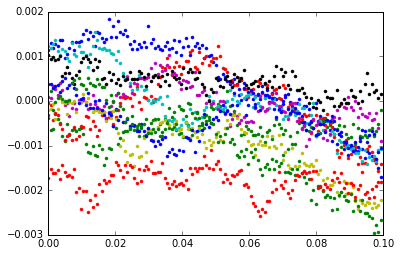

In [14]:
for i in range(10):
    plt.plot(x, gp.sample(x) + typical_error*np.random.randn(x.shape[0]), '.')

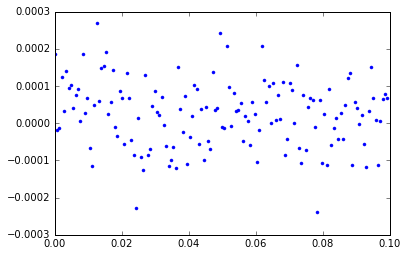

In [15]:
plt.plot(x, normalized_lc.fluxes[:x.shape[0]] - 1, '.')

In [16]:
# fake_times = np.arange(0, 1, 1./60/24)
# fake_fluxes = gp.sample(fake_times) + typical_error * np.random.randn(len(fake_times))

# # lags, acf = interpacf.interpolated_acf(fake_times, fake_fluxes, cadences=np.arange(len(fake_times)))

# from interpacf import autocorrelation

# lags = 1./60/24 * np.arange(len(fake_times))
# acf = autocorrelation(fake_fluxes)

# plt.plot(lags, acf)
# plt.plot(bin_centers, kernel(results, bin_centers), lw=3, label='best-fit')


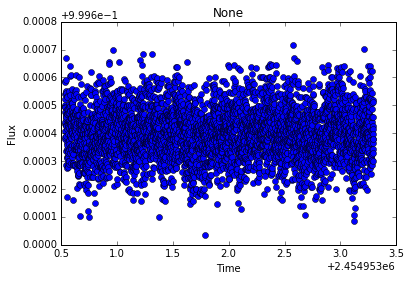

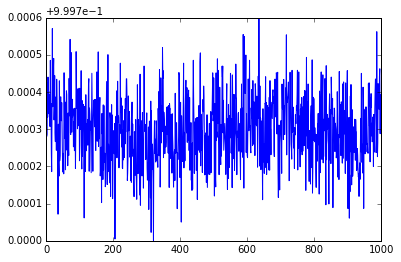

In [17]:
chunks[0].plot()

plt.plot(chunks[0].fluxes[:1000])

In [18]:
custom_kernel.pars

array([  2.06583227e-06,   3.65654073e-01,   9.99539596e-01,
         7.91655863e-01])

In [75]:
# from george import BasicSolver, HODLRSolver
# from george.kernels import Matern32Kernel, ExpSquaredKernel, ExpKernel

# m_kernel = 3e-4 * ExpSquaredKernel(1)
# gp = GP(m_kernel, solver=BasicSolver)

# n = len(chunks[0].times)
# gp.compute(chunks[0].times.jd[:n])

# def min_this(x):
#     gp.kernel[:] = x
#     return -gp.lnlikelihood(chunks[0].fluxes[:n] - np.median(chunks[0].fluxes))

# def grad_min_this(x):
#     gp.kernel[:] = x
#     return -gp.grad_lnlikelihood(chunks[0].fluxes[:n] - np.median(chunks[0].fluxes), quiet=True)

# from scipy.optimize import fmin_l_bfgs_b, fmin_bfgs, fmin_ncg

# # results = fmin_bfgs(min_this, m_kernel.pars, fprime=grad_min_this)

# bounds = [(0.0, None),
#           (np.log(3./60/24), None)]

# results = fmin_ncg(min_this, m_kernel.pars, fprime=grad_min_this)#, bounds=bounds)


# # gp.optimize(chunks[0].times.jd[:1000], chunks[0].fluxes[:1000] - np.median(chunks[0].fluxes), 
# #             typical_error, dims=[0])

In [ ]:
results

/astro/users/bmmorris/.local/lib/python3.5/site-packages/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


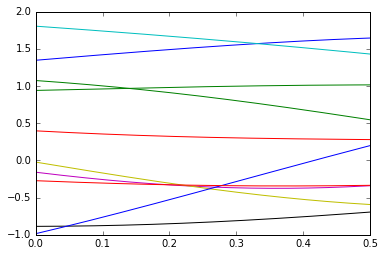

In [73]:
fake_times = np.arange(0, 0.5, 1./60/24)

gp.kernel[:] = results[0]

for i in range(10): 
    plt.plot(fake_times, gp.sample(fake_times))